<br><br>

<img src="https://raw.githubusercontent.com/SmilodonCub/DS4VS/master/Homework/melt.png" width="100%" style="margin-left:auto; margin-right:auto">


<br>

# Homework3: `pandas` DataFrame manipulations

## Part 1: `pandas` Melting and Pivoting

In this first section we will melt and pivot a pandas dataframe. A smart combination of manipulating and aggregating the dataframe will help us extract different insights without having to write messy for loops. We will use a simple toy dataset to illustrate each data restructuring method.  

First, let's define a few terms:  

* **Aggregating** - Condensing the data by grouping like observations and producing summary metrics to characterize the new grouping. Aggregated data will typically have a smaller sized dataframe as a result.
* **Wide Data** - each row holds more than one observations for a given value of index feature(s)
* **Long Data** - each row holds one observation 
* **Melting** - Restructuring the data from a 'wide' to a 'long' format. The data is reshaped so that each row holds only one observation for a particular category. Also called 'pivoting long'.
* **Pivoting** - Restructuring the data from a 'long' to a 'wide' format. The data is reshape typically into categorical columns. Also called 'pivoting wide'.

Now to import the data

In [1]:
# Let's set up with these libraries handy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# importing our tiny toy data set as a pandas dataframe
url = 'https://raw.githubusercontent.com/SmilodonCub/DS4VS/master/Homework/flights.csv'
col_names = ['Carrier', 'Status', 'LAX', 'PHX', 'SAN', 'SFO', 'SEA']
flights = pd.read_csv( url, encoding= 'unicode_escape' )
flights.columns = col_names
flights = flights.ffill() #will fill in missing values (default along column axis)

print( flights.shape )
flights.head()

(4, 7)


,Carrier,Status,LAX,PHX,SAN,SFO,SEA
0,ALASKA,on time,497,221,212,503,1841
1,ALASKA,delayed,62,12,20,102,305
2,AM West,on time,694,4840,383,320,201
3,AM West,delayed,117,415,65,129,61



### Morphing Shapes...

Currently, the `flights` dataframe is organized in a wide format. Observe how each row holds multiple observations for a single condition. For example, `flights.iloc[0]` holds observations summarizing the number of 'on time' 'ALASKA' flights for 'LAX', 'PHX', 'SAN', 'SFO' and 'SEA'.  

For such a small dataset, this format makes for a very easy to understand summary of the data to human eyes, but it it is not very convenient for analysis. For example, what if we would like to compare the proportion of flights that are on-time vs delayed for each airport and carrier. This would be complicated with the wide format!  

Let's melt the dataframe into the long format:  

In [3]:
# use the pd.melt() method to selectively melt the airport columns 
# while keeping the Carrier & Status as index columns

flights_long = pd.melt( flights, id_vars = ['Carrier', 'Status'], 
                       value_vars = ['LAX', 'PHX', 'SAN', 'SFO', 'SEA'], 
                       var_name = 'Airport', 
                       value_name='Total' )

flights_long

,Carrier,Status,Airport,Total
0,ALASKA,on time,LAX,497
1,ALASKA,delayed,LAX,62
2,AM West,on time,LAX,694
3,AM West,delayed,LAX,117
4,ALASKA,on time,PHX,221
5,ALASKA,delayed,PHX,12
6,AM West,on time,PHX,4840
7,AM West,delayed,PHX,415
8,ALASKA,on time,SAN,212
9,ALASKA,delayed,SAN,20


<br>

Great! we now have a looong flights dataframe.  
But, let's say we are interested in calculating the percent of on-time/delayed flights for each Carrier/Status condition. That would be hard to compute from this configuration of the dataframe. We'd have to work hard to find the total for each Carrier/Status by looping alternate rows and we'd need to create a new data structure to hold the results...sounds messy & unnecessary because it is. Let's just restructure the data in a way that gives us the 'on-time' and 'delayed' observations as new feature columns by pivoting the dataframe.  

We will now pivot flights_long with 'Carrier' and 'Airport' serving as our index columns while we widen the total into new columns for 'on-time' and 'delayed':  

In [4]:
flights_status = flights_long.pivot( index = ['Carrier','Airport'], columns = 'Status', values = 'Total')
flights_status

Status           delayed  on time
Carrier Airport                  
ALASKA  LAX           62      497
        PHX           12      221
        SAN           20      212
        SEA          305     1841
        SFO          102      503
AM West LAX          117      694
        PHX          415     4840
        SAN           65      383
        SEA           61      201
        SFO          129      320

<br>

The data is now somewhere inbetween long and wide, but just where we need it for our purposes.  
Now we can easily find the total flights by taking the sum of the 'delayed' + 'on-time' columns. It is also easy to then calculate the percentage for each observation....

In [5]:
flights_status['Total'] = flights_status['delayed'] + flights_status['on time']
flights_status['p_delayed'] = flights_status['delayed']/flights_status['Total']*100
flights_status['p_ontime'] = flights_status['on time']/flights_status['Total']*100
flights_status = flights_status.round( 2 )
flights_status = flights_status.reset_index()
flights_status

Status,Carrier,Airport,delayed,on time,Total,p_delayed,p_ontime
0,ALASKA,LAX,62,497,559,11.09,88.91
1,ALASKA,PHX,12,221,233,5.15,94.85
2,ALASKA,SAN,20,212,232,8.62,91.38
3,ALASKA,SEA,305,1841,2146,14.21,85.79
4,ALASKA,SFO,102,503,605,16.86,83.14
5,AM West,LAX,117,694,811,14.43,85.57
6,AM West,PHX,415,4840,5255,7.90,92.10
7,AM West,SAN,65,383,448,14.51,85.49
8,AM West,SEA,61,201,262,23.28,76.72
9,AM West,SFO,129,320,449,28.73,71.27


<br>

We can do a quick visualization of the data...

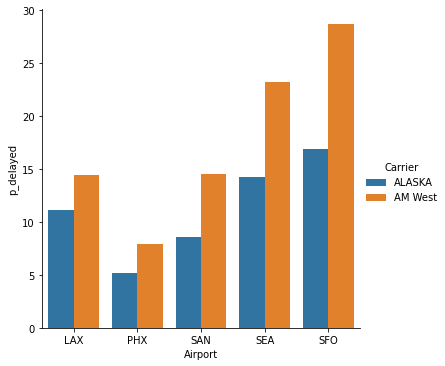

In [6]:
# visualize the percentage of delayed flights for the airlines for each destination
fig = sns.catplot( data = flights_status,
                  kind = 'bar',
                  x = 'Airport',
                  y = 'p_delayed',
                  hue = 'Carrier'
                 )

<br>

From the figure above we can see that AM West flights are more likely to be delayed at all given airports. 

Next we would like to answer a different question about the data: What are the total number of 'delayed' and 'on time' flights for each airline? This will require aggregating our data into groups for each airline: 

In [6]:
# aggregate the data to find the total number of flights for each airline
#    1) group on the column 'Carrier'
#    2) take the sum of the numeric columns
#    3) drop the 'p_' columns because they don't make sense as a summed value
flights_status.groupby( 'Carrier' ).sum( ).drop( columns=['p_delayed', 'p_ontime'])

Status,delayed,on time,Total
Carrier,,,
ALASKA,501,3274,3775
AM West,787,6438,7225


<br>

### Now you try!

**Question 1** Using the `flights_status` dataframe, aggregate the data to get the total flights grouped by 'Airport'

In [7]:
flights_status.groupby('Airport').sum().drop(columns = ['p_delayed','p_ontime'])

Status,delayed,on time,Total
Airport,,,
LAX,179,1191,1370
PHX,427,5061,5488
SAN,85,595,680
SEA,366,2042,2408
SFO,231,823,1054


**Question 2** The original format of the dataframe was very friendly to human eyes, but the values are difficult to draw insights from. Can you reshape the `flights_status` dataframe back to the original (4, 7) using the new percentage values you computed above?

In [9]:
flights_status

Status,Carrier,Airport,delayed,on time,Total,p_delayed,p_ontime
0,ALASKA,LAX,62,497,559,11.09,88.91
1,ALASKA,PHX,12,221,233,5.15,94.85
2,ALASKA,SAN,20,212,232,8.62,91.38
3,ALASKA,SEA,305,1841,2146,14.21,85.79
4,ALASKA,SFO,102,503,605,16.86,83.14
5,AM West,LAX,117,694,811,14.43,85.57
6,AM West,PHX,415,4840,5255,7.90,92.10
7,AM West,SAN,65,383,448,14.51,85.49
8,AM West,SEA,61,201,262,23.28,76.72
9,AM West,SFO,129,320,449,28.73,71.27


In [38]:
melted_df = pd.melt( flights_status, id_vars = ['Carrier','Airport'], 
                       value_vars = ['p_delayed','p_ontime'], 
                       var_name = 'Status',
                       value_name= 'value')
melted_df

,Carrier,Airport,Status,value
0,ALASKA,LAX,p_delayed,11.09
1,ALASKA,PHX,p_delayed,5.15
2,ALASKA,SAN,p_delayed,8.62
3,ALASKA,SEA,p_delayed,14.21
4,ALASKA,SFO,p_delayed,16.86
5,AM West,LAX,p_delayed,14.43
6,AM West,PHX,p_delayed,7.90
7,AM West,SAN,p_delayed,14.51
8,AM West,SEA,p_delayed,23.28
9,AM West,SFO,p_delayed,28.73


In [39]:
original_df = melted_df.pivot( index = ['Carrier','Status'], columns = 'Airport', values = 'value')
original_df
#This is the closest I could get

Airport              LAX    PHX    SAN    SEA    SFO
Carrier Status                                      
ALASKA  p_delayed  11.09   5.15   8.62  14.21  16.86
        p_ontime   88.91  94.85  91.38  85.79  83.14
AM West p_delayed  14.43   7.90  14.51  23.28  28.73
        p_ontime   85.57  92.10  85.49  76.72  71.27

**Question 3** This figure above plots the percentage of delayed flights per destination for each carrier. We can think of these plotted values as the conditional probability, $\mbox{P}_{\mbox{Airport}}(\mbox{delayed}|\mbox{ALASKA})$. What if we are really interested in a different question: For a given 'Airport', what is the propability of flights for a given 'Carrier'

PCarrier(delayed|AIRPORT) 

**Optional** We had already calculated the conditional probability (what is the probability that a flight is delayed given it is ALASKA|AM WEST). Question 3 finds the prior (what is the probabilty a flight to an Airport is ALASKA|AM WEST. Can you invert the conditional probability, $\mbox{P}_{\mbox{Airport}}(\mbox{ALASKA}|\mbox{delayed})$?

## Part 2: Working with your own data

Think back to Homework #2. Use the code we developed there as a framework to wrangle some data of your own into a pandas dataframe. **Bonus**: can you find an application for one of the dataframe manipulations reviewed in this homework assignment (aggregating, melting, pivoting)  

<br><br>

In [ ]:
test_ERG = 'C:\\Users\\sabin\\Desktop\\DataScience\\ERG_test_data.txt'
ERG_df = pd.read_csv( test_ERG, skiprows = range( 0, 38 ),  sep = '\t', encoding= 'unicode_escape'  )
#ERG_df
data = ERG_df[ERG_df.columns[6:8]]
print(data)

In [ ]:
#print(type(temp_data))
data = temp_data[ temp_data.iloc[:,0]>= 0 ]    

In [ ]:
mask = data[(data['Time (ms)'] <= 1999) | (data['Time (ms)'] >=5600 & data['Time (ms)'] <= 8599) | (data['Time (ms)'] >= 13400 & data['Time (ms)'] <= 17799) | data(['Time (ms)'] >= 21400 & data['Time (ms)'] <= 24399) | ( data['Time (ms)'] >= 29200)]



In [ ]:
print(mask)
